# 0. Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)
import shap
import warnings
warnings.filterwarnings('ignore')

# 1. Veri Setinin Yüklenmesi

In [2]:
wine = load_wine()
X = wine.data
y = wine.target

df = pd.DataFrame(X, columns=wine.feature_names)
df['target'] = y

print("\nVeri seti şekli:", df.shape)
print("\nİlk 5 satır:")
print(df.head())

print("\nHedref değişken dağılımı:")
print(df['target'].value_counts().sort_index())


Veri seti şekli: (178, 14)

İlk 5 satır:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_di

# 2. Veri Seti Kalite Kontrolleri

In [3]:
print("\n2.1 Eksik Değer Analizi:")
missing = df.isnull().sum()
print(missing)
print(f"Toplam eksik değer: {missing.sum()}")


2.1 Eksik Değer Analizi:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64
Toplam eksik değer: 0


In [4]:
print("\n2.2 Aykırı Değer Analizi (IQR Yöntemi):")
def detect_outliers_iqr(df_temp):
    outlier_indices = []
    numeric_cols = df_temp.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df_temp[col].quantile(0.25)
        Q3 = df_temp[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_idx = df_temp[(df_temp[col] < lower) | (df_temp[col] > upper)].index
        outlier_indices.extend(outlier_idx)
    return list(set(outlier_indices))


2.2 Aykırı Değer Analizi (IQR Yöntemi):


In [5]:
outlier_indices = detect_outliers_iqr(df.drop('target', axis=1))
print(f"Aykırı değer sayısı: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.2f}%)")
print("Aykırı değerlerin modele etkisi: Sınıflandırma performansını düşürebilir, ancak Wine veri seti ")
print("doğal olarak dengeli olduğundan etkisi minimal olacaktır.")

Aykırı değer sayısı: 17 (9.55%)
Aykırı değerlerin modele etkisi: Sınıflandırma performansını düşürebilir, ancak Wine veri seti 
doğal olarak dengeli olduğundan etkisi minimal olacaktır.


In [6]:
print("\n2.3 Veri Tipi ve Dağılım İncelemesi:")
print(f"Sayısal değişken sayısı: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Kategorik değişken sayısı: {len(df.select_dtypes(include=['object']).columns)}")
print("\nVeri tipleri:")
print(df.dtypes)


2.3 Veri Tipi ve Dağılım İncelemesi:
Sayısal değişken sayısı: 14
Kategorik değişken sayısı: 0

Veri tipleri:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object


# 3. Keşifsel Veri Analizi (EDA)

In [7]:
print("\n3.1 İstatistiksel Özellikler:")
stats_df = df.drop('target', axis=1).describe().T
stats_df['Q1'] = df.drop('target', axis=1).quantile(0.25)
stats_df['Q3'] = df.drop('target', axis=1).quantile(0.75)
print(stats_df[['mean', '50%', 'min', 'max', 'std', 'Q1', 'Q3']])


3.1 İstatistiksel Özellikler:
                                    mean      50%     min      max  \
alcohol                        13.000618   13.050   11.03    14.83   
malic_acid                      2.336348    1.865    0.74     5.80   
ash                             2.366517    2.360    1.36     3.23   
alcalinity_of_ash              19.494944   19.500   10.60    30.00   
magnesium                      99.741573   98.000   70.00   162.00   
total_phenols                   2.295112    2.355    0.98     3.88   
flavanoids                      2.029270    2.135    0.34     5.08   
nonflavanoid_phenols            0.361854    0.340    0.13     0.66   
proanthocyanins                 1.590899    1.555    0.41     3.58   
color_intensity                 5.058090    4.690    1.28    13.00   
hue                             0.957449    0.965    0.48     1.71   
od280/od315_of_diluted_wines    2.611685    2.780    1.27     4.00   
proline                       746.893258  673.500  278.00  

In [8]:
print("\n3.2 Korelasyon Matrisi:")
corr_matrix = df.drop('target', axis=1).corr()
print("En yüksek korelasyonlu 3 çift özellik:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                          abs(corr_matrix.iloc[i, j])))
top_corr = sorted(corr_pairs, key=lambda x: x[2], reverse=True)[:3]
for feat1, feat2, corr in top_corr:
    print(f"{feat1} <-> {feat2}: {corr:.4f}")


3.2 Korelasyon Matrisi:
En yüksek korelasyonlu 3 çift özellik:
total_phenols <-> flavanoids: 0.8646
flavanoids <-> od280/od315_of_diluted_wines: 0.7872
total_phenols <-> od280/od315_of_diluted_wines: 0.6999


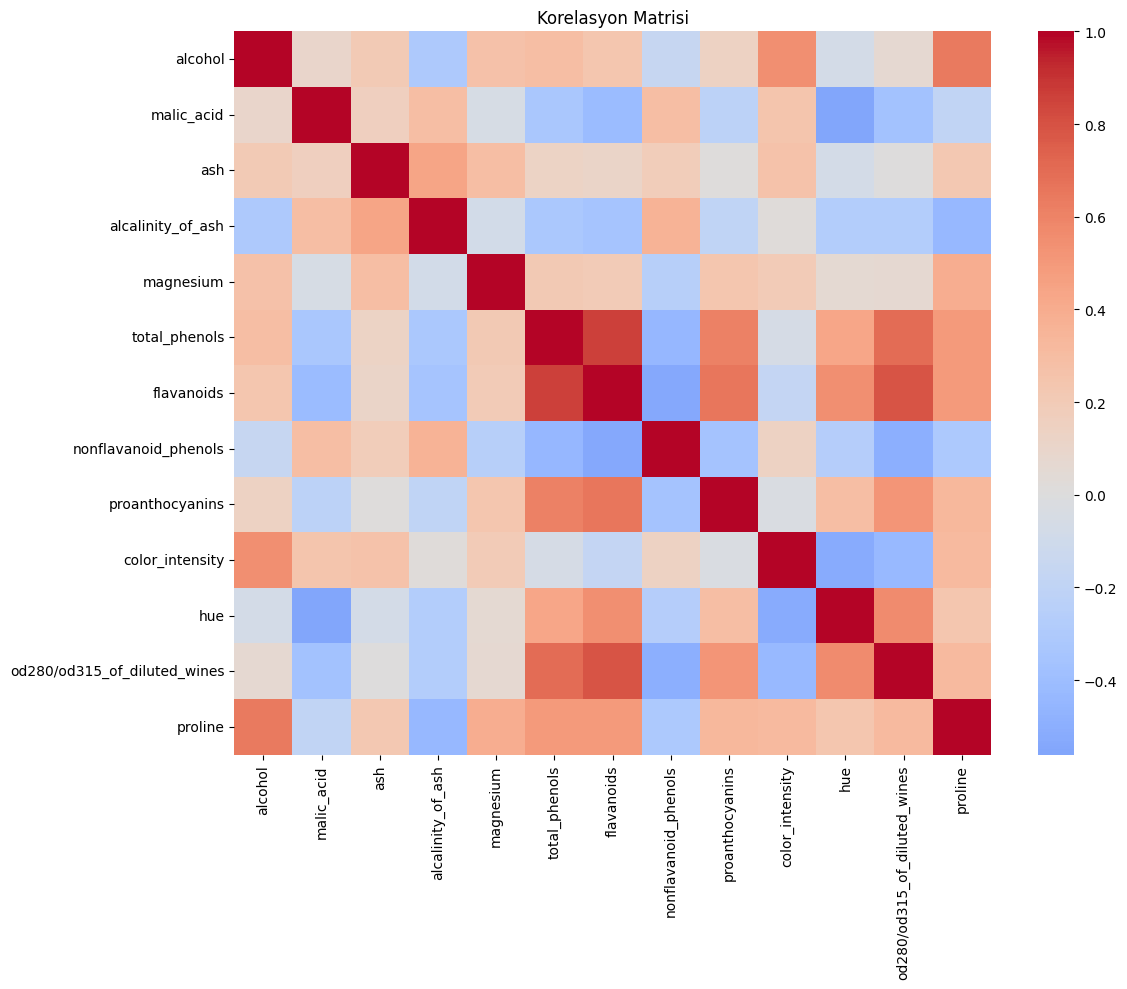

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=ax)
plt.title('Korelasyon Matrisi')
plt.tight_layout()
plt.show()
plt.savefig('correlation_matrix.png', dpi=100)
plt.close()


3.3 Boxplot Analizi:


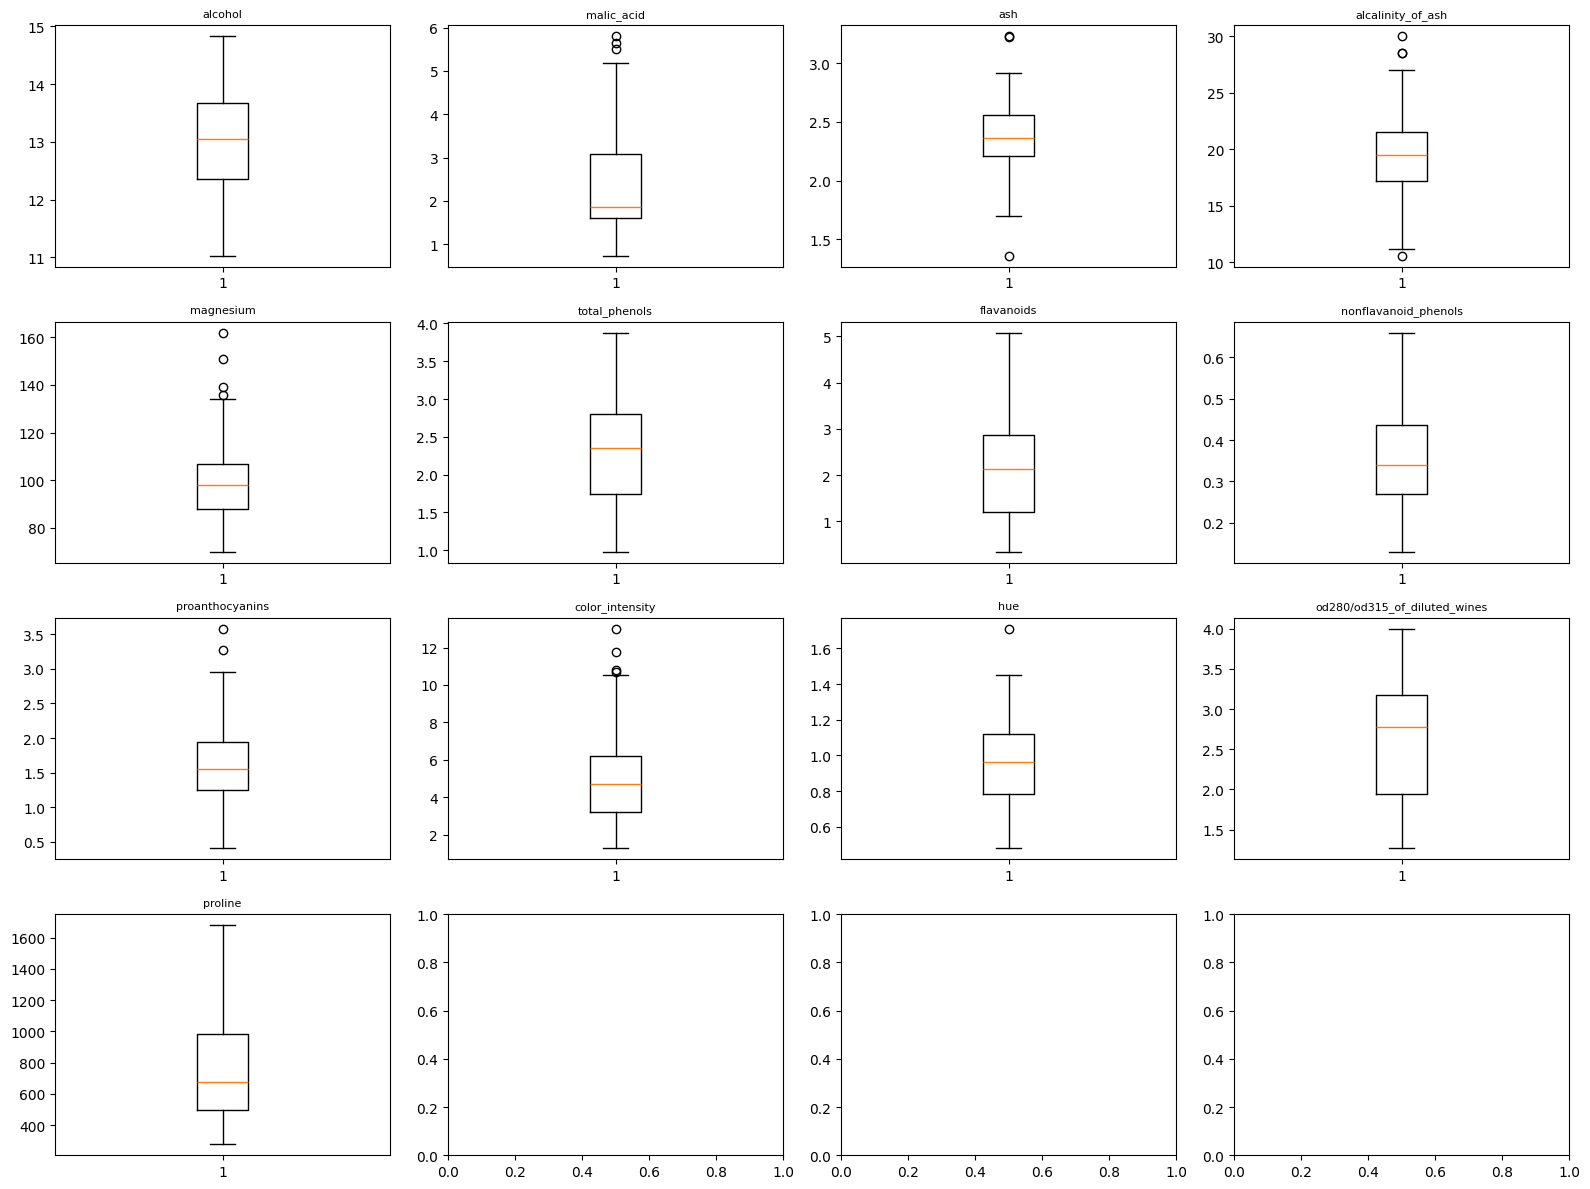

In [12]:
print("\n3.3 Boxplot Analizi:")
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for idx, col in enumerate(df.drop('target', axis=1).columns):
    ax = axes[idx // 4, idx % 4]
    ax.boxplot(df[col])
    ax.set_title(col, fontsize=8)
plt.tight_layout()
plt.show()
plt.savefig('boxplots.png', dpi=100)
plt.close()

# 4. Veri Ölçeklendirme

In [16]:
X_scaled = RobustScaler().fit_transform(X)
print(f"Ölçeklendirme tamamlandı. Şekil: {X_scaled.shape}")

Ölçeklendirme tamamlandı. Şekil: (178, 13)


# 5. Veri Setinin Bölünmesi

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [18]:
print(f"Training seti: {len(X_train)} (%{len(X_train)/len(X_scaled)*100:.1f})")
print(f"Validation seti: {len(X_val)} (%{len(X_val)/len(X_scaled)*100:.1f})")
print(f"Test seti: {len(X_test)} (%{len(X_test)/len(X_scaled)*100:.1f})")

Training seti: 124 (%69.7)
Validation seti: 18 (%10.1)
Test seti: 36 (%20.2)


# 6. Boyut İndirgeme

In [19]:
print("\n6.1 PCA (Principal Component Analysis):")
pca = PCA()
pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
mean_var = exp_var.mean()
n_components_pca = np.argmax(cum_var >= cum_var[-1] * 0.95) + 1

print(f"PCA bileşen sayısı (95% varyans): {n_components_pca}")


6.1 PCA (Principal Component Analysis):
PCA bileşen sayısı (95% varyans): 9


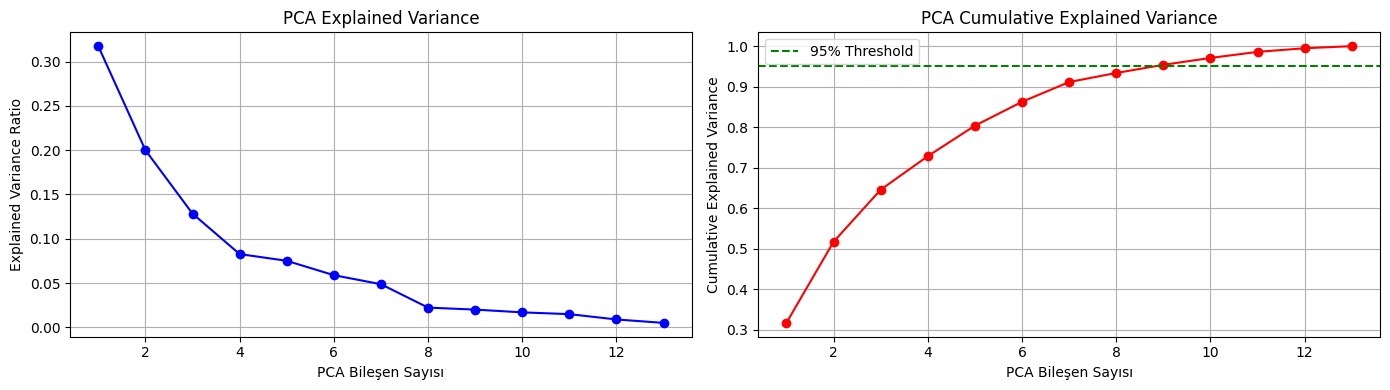

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(range(1, len(exp_var)+1), exp_var, 'bo-')
ax1.set_xlabel('PCA Bileşen Sayısı')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance')
ax1.grid()

ax2.plot(range(1, len(cum_var)+1), cum_var, 'ro-')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% Threshold')
ax2.set_xlabel('PCA Bileşen Sayısı')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('PCA Cumulative Explained Variance')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()
plt.savefig('pca_variance.png', dpi=100)
plt.close()

In [21]:
pca = PCA(n_components=n_components_pca)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [22]:
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

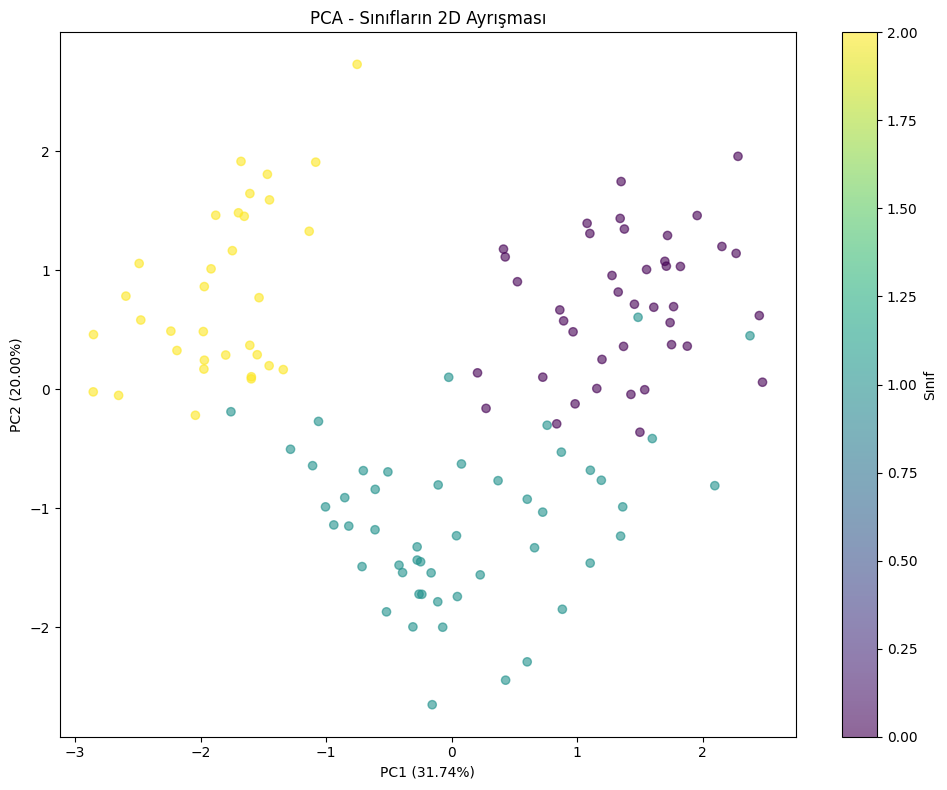

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, 
                     cmap='viridis', alpha=0.6)
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
ax.set_title('PCA - Sınıfların 2D Ayrışması')
plt.colorbar(scatter, ax=ax, label='Sınıf')
plt.tight_layout()
plt.show()
plt.savefig('pca_2d.png', dpi=100)
plt.close()

In [24]:
print("\n6.2 LDA (Linear Discriminant Analysis):")
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)


6.2 LDA (Linear Discriminant Analysis):


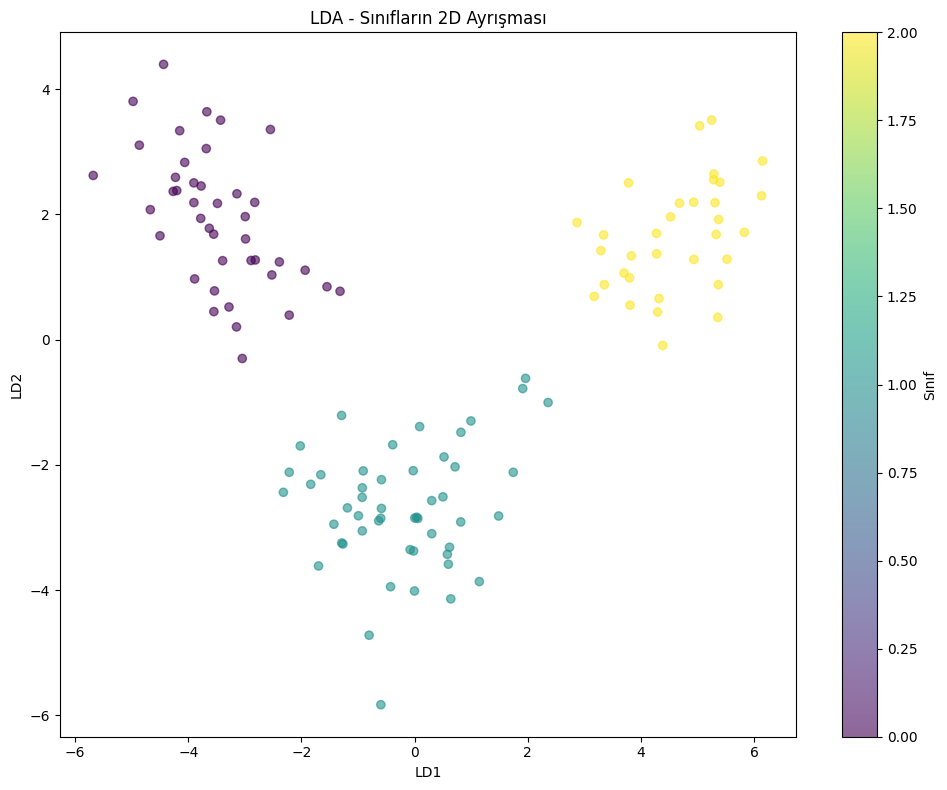

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, 
                     cmap='viridis', alpha=0.6)
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_title('LDA - Sınıfların 2D Ayrışması')
plt.colorbar(scatter, ax=ax, label='Sınıf')
plt.tight_layout()
plt.show()
plt.savefig('lda_2d.png', dpi=100)
plt.close()

# 7. Modellerin Kurulması ve Validasyon

In [29]:
def get_algorithm_instance(algo_name):
    """Her veri versiyonu için yeni model instance'ı oluştur"""
    if algo_name == 'Logistic Regression':
        return LogisticRegression(max_iter=1000, random_state=42)
    elif algo_name == 'Decision Tree':
        return DecisionTreeClassifier(random_state=42)
    elif algo_name == 'Random Forest':
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif algo_name == 'XGBoost':
        return XGBClassifier(random_state=42, verbose=0)
    elif algo_name == 'Naive Bayes':
        return GaussianNB()

In [30]:
algorithm_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Naive Bayes']

In [37]:
data_versions = {
    'Ham Veri': (X_train, X_val, X_test),
    'PCA': (X_train_pca, X_val_pca, X_test_pca),
    'LDA': (X_train_lda, X_val_lda, X_test_lda)
}

results = []
models_dict = {}

for data_name, (X_tr, X_v, X_te) in data_versions.items():
    for algo_name in algorithm_names:
        model = get_algorithm_instance(algo_name)
        model.fit(X_tr, y_train)
        y_pred = model.predict(X_v)
        y_pred_proba = model.predict_proba(X_v)[:, 1] if len(np.unique(y)) == 2 else model.predict_proba(X_v).max(axis=1)
        
        try:
            roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr')
        except Exception as e:
            roc_auc = 0.0
        
        results.append({
            'Veri': data_name,
            'Algoritma': algo_name,
            'Accuracy': accuracy_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_val, y_pred, average='weighted', zero_division=0),
            'F1': f1_score(y_val, y_pred, average='weighted', zero_division=0),
            'ROC-AUC': roc_auc
        })
        
        models_dict[f"{data_name}_{algo_name}"] = model

In [38]:
results_df = pd.DataFrame(results)
print("\nTüm Modellerin Validation Performansı:")
print(results_df.to_string(index=False))


Tüm Modellerin Validation Performansı:
    Veri           Algoritma  Accuracy  Precision   Recall       F1  ROC-AUC
Ham Veri Logistic Regression  1.000000   1.000000 1.000000 1.000000      0.0
Ham Veri       Decision Tree  0.888889   0.913580 0.888889 0.890222      0.0
Ham Veri       Random Forest  1.000000   1.000000 1.000000 1.000000      0.0
Ham Veri             XGBoost  1.000000   1.000000 1.000000 1.000000      0.0
Ham Veri         Naive Bayes  1.000000   1.000000 1.000000 1.000000      0.0
     PCA Logistic Regression  0.944444   0.951389 0.944444 0.943210      0.0
     PCA       Decision Tree  0.777778   0.777778 0.777778 0.777778      0.0
     PCA       Random Forest  0.777778   0.814815 0.777778 0.777778      0.0
     PCA             XGBoost  0.722222   0.729167 0.722222 0.722222      0.0
     PCA         Naive Bayes  0.944444   0.951389 0.944444 0.943210      0.0
     LDA Logistic Regression  1.000000   1.000000 1.000000 1.000000      0.0
     LDA       Decision Tree  0.9444

In [39]:
best_idx = results_df['Accuracy'].idxmax()
best_result = results_df.loc[best_idx]
print(f"\nEn İyi Model: {best_result['Veri']} - {best_result['Algoritma']}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")


En İyi Model: Ham Veri - Logistic Regression
Accuracy: 1.0000


# 8. En İyi Modelin Test Üzerinde Değerlendirilmesi

In [40]:
best_model_name = f"{best_result['Veri']}_{best_result['Algoritma']}"
best_model = models_dict[best_model_name]

if best_result['Veri'] == 'Ham Veri':
    X_test_best = X_test
elif best_result['Veri'] == 'PCA':
    X_test_best = X_test_pca
else:
    X_test_best = X_test_lda

In [41]:
y_test_pred = best_model.predict(X_test_best)
y_test_pred_proba = best_model.predict_proba(X_test_best)

In [42]:
print(f"\n9.1 Performans Metrikleri:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted', zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred, average='weighted', zero_division=0):.4f}")


9.1 Performans Metrikleri:
Accuracy: 0.9722
Precision: 0.9744
Recall: 0.9722
F1-Score: 0.9723


In [43]:
try:
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
    print(f"ROC-AUC: {roc_auc_test:.4f}")
except:
    print("ROC-AUC: Hesaplanmadı")

ROC-AUC: 1.0000


In [44]:
print(f"\n9.2 Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Tahmin')
ax.set_ylabel('Gerçek')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=100)
plt.close()


9.2 Confusion Matrix:


In [45]:
print(f"\n9.3 ROC Eğrisi:")
fig, ax = plt.subplots(figsize=(10, 8))
for class_idx in range(len(np.unique(y))):
    fpr, tpr, _ = roc_curve((y_test == class_idx).astype(int), 
                            y_test_pred_proba[:, class_idx])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Sınıf {class_idx} (AUC={roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Eğrisi')
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=100)
plt.close()


9.3 ROC Eğrisi:


# 9. SHAP Açıklanabilirlik Analizi

In [46]:
print("\n10.1 En İyi Model için SHAP Analizi:")

if best_result['Veri'] == 'Ham Veri':
    X_val_best = X_val
    feature_names = wine.feature_names
elif best_result['Veri'] == 'PCA':
    X_val_best = X_val_pca
    feature_names = [f'PC_{i+1}' for i in range(X_val_pca.shape[1])]
else:
    X_val_best = X_val_lda
    feature_names = [f'LD_{i+1}' for i in range(X_val_lda.shape[1])]


10.1 En İyi Model için SHAP Analizi:


In [47]:

if isinstance(best_model, (DecisionTreeClassifier, RandomForestClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.KernelExplainer(best_model.predict, X_val_best[:100])

In [48]:
shap_values = explainer.shap_values(X_val_best)

  0%|          | 0/18 [00:00<?, ?it/s]

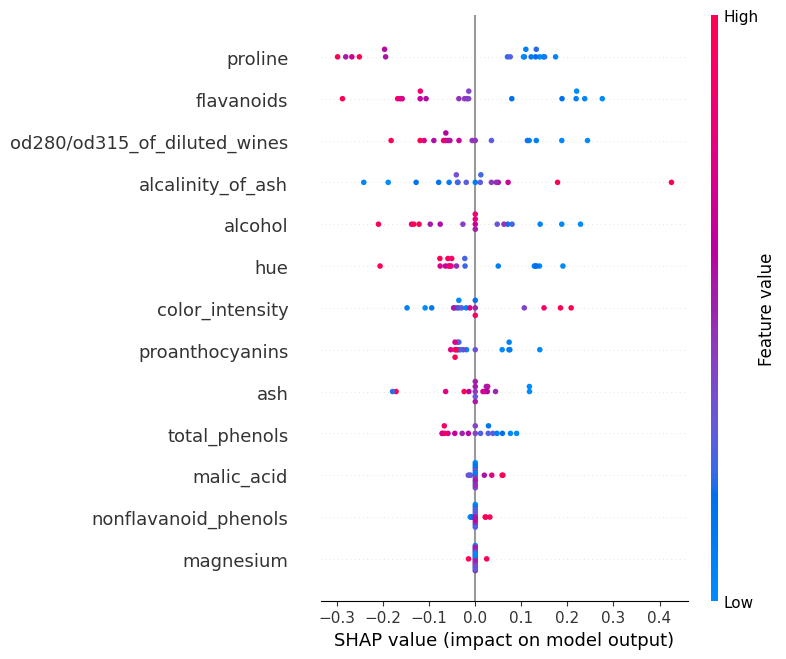

In [51]:
fig = plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_val_best, feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_val_best, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

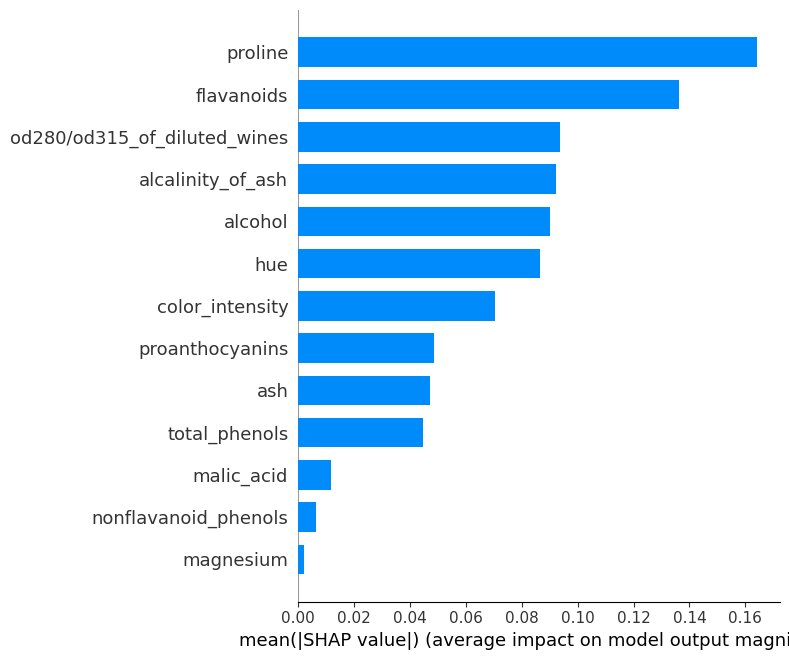

In [52]:
fig = plt.figure(figsize=(10, 6))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_val_best, feature_names=feature_names, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values, X_val_best, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()